In [1]:
# Import necessary libraries
import pandas as pd        # For data manipulation and analysis
import numpy as np         # For numerical operations
import warnings            # To suppress warnings

# Visualization libraries
import matplotlib.pyplot as plt  # For plotting
plt.style.use('ggplot')          # Use ggplot style for consistent plots
import seaborn as sns            # Advanced statistical visualization

# Scientific & Statistical libraries
import scipy as sp               # Scientific computations
import statsmodels.api as sm     # Statistical modeling, regression, hypothesis testing

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')
def feature_summary(data, feature):
    """
    Returns a summary of a specific column in a DataFrame based on its type (categorical or numerical).
    
    - For numerical features:
        - Missing value count
        - Count of numerical entries
        - Quartiles: Q1, Q2 (Median), Q3
    
    - For categorical features:
        - Missing value count
        - Count of categorical entries
        - Total number of unique categories
        - Frequency of the top 3 most common categories
    
    Parameters:
        data (pd.DataFrame): Input DataFrame
        feature (str): Column name to analyze
    
    Returns:
        dict: A dictionary containing the computed summary statistics.
    """
    # Count missing values
    missing_values = data[feature].isna().sum()
    
    # Check if the column is categorical or numerical
    if data[feature].apply(lambda x: isinstance(x, str)).sum() > 0:
        # Categorical feature
        total_entries = len(data[feature])
        unique_categories = data[feature].nunique()
        top_categories = data[feature].value_counts().head(3).to_dict()
        
        summary = {
            "Feature Type": "Categorical",
            "Missing Values": missing_values,
            "Total Entries": total_entries,
            "Unique Categories": unique_categories,
            "Top 3 Categories (with counts)": top_categories
        }
    else:
        # Numerical feature
        numeric_values = pd.to_numeric(data[feature], errors='coerce')
        q1 = numeric_values.dropna().quantile(0.25)
        q2 = numeric_values.dropna().median()
        q3 = numeric_values.dropna().quantile(0.75)
        numeric_count = numeric_values.dropna().count()
        max = numeric_values.dropna().max()
        min = numeric_values.dropna().min()
        mean = numeric_values.dropna().mean()
        
        summary = {
            "Feature Type": "Numerical",
            "Missing Values": missing_values,
            "Count of Numeric Entries": numeric_count,
            "Q1 (25%)": q1,
            "Q2 (Median)": q2,
            "Q3 (75%)": q3,
            "Mean":mean,
            "Max":max,
            "Min":min,

        }
    
    return summary


In [2]:
df = pd.read_csv('rawdata.csv')


In [3]:
df.shape

(32886, 85)

In [4]:
# Sayısal dönüşüm denemesi
numeric_converted = pd.to_numeric(df['YearsOfEducation'], errors='coerce')

# Sayısala dönüşemeyen değerler NaN olarak gelir, bunları orijinal değerlerle dolduruyoruz
df['YearsOfEducation'] = numeric_converted.fillna(df['YearsOfEducation'])
import re 

education_map = {
    'highschool': 12,
    'hs': 12,
    'ged': 12,
    'college': 14,
    'some college': 15,
    'associates': 14,
    'bachelors': 16,
    "bachelor's": 16,
    'bsn': 16,
    'masters': 18,
    'mba': 18,
    'pharmd': 18,
    'postgraduate': 18,
    'phd': 20,
    'doctorate': 20,
    'md': 20,
    'jd': 20,
    'np': 20,
    'engineer': 18,
}

# Fonksiyon: Yıl tahmini
def estimate_years(value):
    # 16+ gibi değerler için
    if re.match(r'^\d+\+$', str(value)):
        return int(value.strip('+')) + 2
    # 12 yrs, 14.5+ gibi detaylı formatlar
    elif re.match(r'^\d+\.?\d*\s*yrs?', str(value)):
        return float(re.search(r'\d+\.?\d*', value).group())
    # Sözlükten tahminler
    elif isinstance(value, str):
        value_lower = value.lower()
        for key, year in education_map.items():
            if key in value_lower:
                return year
        # Varsayılan tahminler
        if 'school' in value_lower:
            return 12
        if 'college' in value_lower or 'university' in value_lower:
            return 14
    return None  # Bilinmeyen değerler için

# Tahmin edilen yılları orijinal sütuna yaz
df.loc[df['YearsOfEducation'].apply(lambda x: isinstance(x, str)), 'YearsOfEducation'] = (
    df['YearsOfEducation'].apply(estimate_years)
)

In [5]:
values_to_replace = [
    'Race: [other] or [not stated]', 
    'American Indian or Alaska Native', 
    'Native Hawaiian or Other Pacific Islander', 
    'Hispanic or Latino'
]

# Belirtilen değerleri "Others" olarak değiştir
df['MaternalRace'] = df['MaternalRace'].replace(values_to_replace, 'Others')

In [6]:
values_to_replace = [
       'domestic partner',
       'Divorced state', 
       'Marital state unknown', 
       'Widow',
       'Separated from cohabitee', 
       'Other - Marital Status',
       'Patient data refused']
df['LatestMaritalStatus'] = df['LatestMaritalStatus'].replace(values_to_replace, 'Others')


In [7]:
df['AnyInfection'] = df[['HepB_PositiveDuringPregnancy', 'HCV_PositiveDuringPregnancy', 
                         'HIV_PositiveDuringPregnancy', 'SyphilisPositiveDuringPregnancy', 
                         'GBS_PositiveDuringPregnancy']].apply(lambda row: 'Y' if 'Y' in row.values else 'N', axis=1)

In [8]:
df.MaxHeartRate.replace(1036,136,inplace=True)
df.MaxHeartRate.replace(436,136,inplace=True)

In [ ]:
median_value = df['PercentWeightLoss'].median()
df.loc[df['PercentWeightLoss'] > 10, 'PercentWeightLoss'] = median_value
df.loc[df['PercentWeightLoss'] < -15, 'PercentWeightLoss'] = median_value
df['PercentWeightLoss'] = df['PercentWeightLoss'].apply(lambda x:-x if x>0 else x)

In [ ]:
df['CV'] = df[dv].replace({
    'C-Section':1,
    'C-Section|Vaginal':1, 
    'Vaginal':0, 
    'VBAC':0,
    'C-Section|VBAC':1, 
    'Vaginal|VBAC':0,
    'Spontaneous':0,
    'Vacuum':0
}).fillna(0)

In [9]:
df['Desaturations'].value_counts()

Desaturations
N    32362
Y      409
Name: count, dtype: int64

In [10]:
feature_summary(df,'Smoking during pregnancy')

{'Feature Type': 'Categorical',
 'Missing Values': 0,
 'Total Entries': 32886,
 'Unique Categories': 2,
 'Top 3 Categories (with counts)': {'N': 31589, 'Y': 1297}}

In [11]:
df.Cord_pH_Venous_Date.value_counts()
#df.LatestMaritalStatus.unique()

Cord_pH_Venous_Date
30:00.0    298
00:00.0    283
10:00.0    243
20:00.0    241
15:00.0    241
40:00.0    234
50:00.0    223
45:00.0    221
25:00.0    183
05:00.0    176
55:00.0    169
02:00.0    165
46:00.0    157
52:00.0    156
35:00.0    155
59:00.0    154
54:00.0    152
28:00.0    151
23:00.0    151
58:00.0    148
04:00.0    148
44:00.0    148
16:00.0    147
12:00.0    147
27:00.0    146
31:00.0    146
03:00.0    146
48:00.0    145
38:00.0    145
08:00.0    144
09:00.0    142
24:00.0    141
47:00.0    140
18:00.0    140
34:00.0    140
06:00.0    139
36:00.0    139
57:00.0    138
07:00.0    138
14:00.0    138
49:00.0    137
56:00.0    137
39:00.0    137
21:00.0    136
42:00.0    136
41:00.0    134
43:00.0    134
26:00.0    131
17:00.0    130
19:00.0    130
13:00.0    129
37:00.0    128
29:00.0    128
22:00.0    126
32:00.0    126
53:00.0    125
01:00.0    121
11:00.0    118
51:00.0    118
33:00.0    117
Name: count, dtype: int64

In [12]:
df[df.ROM_Time>(60*24)]

,MaternalPatientID,MaternalMedicalRecordNumber,ChildPatientID,ChildMedicalRecordNumber,ChildEncounterID,MaternalAgeAtDelivery,MaternalRace,MaternalLanguage,MyChartAccess,LatestMaritalStatus,...,MinSerumBilirubin,MaxSerumBilirubin,MaxTranscutaneousBilirubin,MinTranscutaneousBilirubin,Phototherapy,FailedHearing,CarSeatTestFailures,FeedingType,PercentWeightLoss,AnyInfection
0,1403211090,40887440,44010453683,88023659,4.405260e+11,37,Black race,English Language,Y,Unmarried person,...,NaN,NaN,5.9,4.9,N,N,NaN,Human Milk,-5.2,Y
1,140Z813318,19520048,44010458043,88025925,4.405260e+11,34,Caucasian,English Language,Y,Currently Married,...,NaN,NaN,4.8,2.8,N,N,NaN,Human Milk,-10.7,Y
2,140Z1834982,60072329,44010461666,88029580,4.405270e+11,28,Black race,English Language,Y,Unmarried person,...,NaN,NaN,11.0,6.2,N,N,NaN,Human Milk,-5.2,N
3,140Z2296222,60610347,44010462021,88029935,4.405270e+11,31,Black race,English Language,Y,Currently Married,...,5.5,6.3,9.4,8.3,N,N,NaN,Human Milk+Formula,-5.0,N
4,4408737430,85940520,44010464769,88032690,4.405280e+11,21,Multiracial,English Language,Y,Currently Married,...,6.0,6.0,8.5,8.5,N,N,NaN,Human Milk,-6.5,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32879,1405288753,84844066,44010816685,88383756,4.405820e+11,23,Multiracial,English Language,Y,Unmarried person,...,8.0,9.9,11.3,8.4,N,Y,NaN,Human Milk,-2.6,N
32880,1406598082,85144226,44010818125,88385197,4.405820e+11,20,Black race,English Language,Y,Unmarried person,...,5.4,5.8,8.2,7.0,N,N,NaN,Human Milk,-3.7,N
32881,1405152490,72257227,44010820635,88387716,4.405830e+11,32,Caucasian,English Language,Y,Others,...,NaN,NaN,3.9,3.9,N,N,NaN,Human Milk,-6.3,Y
32883,140Z2141551,34193223,44010827999,88395092,4.405840e+11,28,Caucasian,English Language,Y,Currently Married,...,6.6,9.5,11.8,6.5,N,N,NaN,Human Milk,-10.1,N


In [61]:
df.LatestMaritalStatus.value_counts()

LatestMaritalStatus
Currently Married    23154
Unmarried person      8466
Others                1264
Name: count, dtype: int64

In [14]:
120/(120+2906), 1091/(1091+28698)

(0.03965631196298744, 0.03662425727617577)

In [65]:
dv = 'PositiveDrugScreenDuringPregnancy'
display(pd.crosstab(df[dv], df['ChildER_VisitFirstMonth']))
display(pd.crosstab(df[dv], df['ChildER_VisitFirstMonth'], normalize='index') * 100)

ChildER_VisitFirstMonth,N,Y
PositiveDrugScreenDuringPregnancy,,
N,30644,1221
Y,960,61


ChildER_VisitFirstMonth,N,Y
PositiveDrugScreenDuringPregnancy,,
N,96.168210,3.831790
Y,94.025465,5.974535


In [66]:
import pingouin as pg
expected, observed, stats = pg.chi2_independence(df, x=dv,
                                                 y='ChildER_VisitFirstMonth')
stats.round(3)

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000,11.559,1.0,0.001,0.019,0.925
1,cressie-read,0.667,11.026,1.0,0.001,0.018,0.913
2,log-likelihood,0.000,10.071,1.0,0.002,0.017,0.888
3,freeman-tukey,-0.500,9.439,1.0,0.002,0.017,0.867
4,mod-log-likelihood,-1.000,8.869,1.0,0.003,0.016,0.846
5,neyman,-2.000,7.892,1.0,0.005,0.015,0.802


In [64]:
value = 'GestAge_Days'
tempdf = df.copy()
tempdf = tempdf.dropna(subset=value)
print(tempdf.shape)
x = tempdf[df.ChildER_VisitFirstMonth=='Y'][value].astype(float)
y = tempdf[df.ChildER_VisitFirstMonth=='N'][value].astype(float)
print('Two sided')
display(pg.mwu(x, y, alternative='two-sided'))

print('Greater')
display(pg.mwu(x, y, alternative='greater'))

print('Less')
display(pg.mwu(x, y, alternative='less'))

(32886, 87)
Two sided


,U-val,alternative,p-val,RBC,CLES
MWU,18695583.0,two-sided,0.000003,-0.077133,0.461433


Greater


,U-val,alternative,p-val,RBC,CLES
MWU,18695583.0,greater,0.999999,-0.077133,0.461433


Less


,U-val,alternative,p-val,RBC,CLES
MWU,18695583.0,less,0.000001,-0.077133,0.538567


<Axes: xlabel='Mother_BMI_AtDelivery', ylabel='Count'>

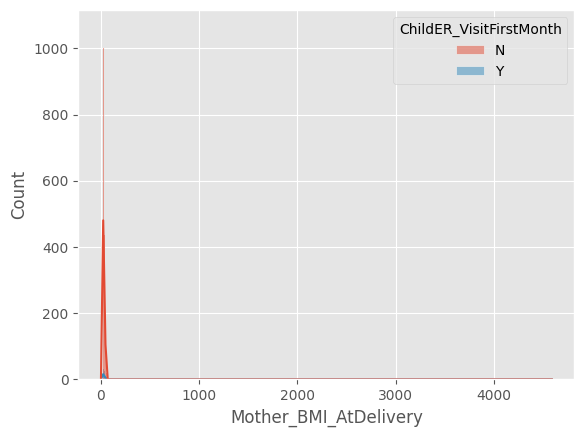

In [47]:
sns.histplot(data=df,x=value,hue='ChildER_VisitFirstMonth',kde=True)

In [42]:
feature_summary(df,value)

{'Feature Type': 'Numerical',
 'Missing Values': 9,
 'Count of Numeric Entries': 32877,
 'Q1 (25%)': -6.8,
 'Q2 (Median)': -5.2,
 'Q3 (75%)': -3.5,
 'Mean': -5.1856647504334346,
 'Max': 0.0,
 'Min': -31.9}

In [49]:
median_value = df['MaxBloodGlucose'].median()
df.loc[df['MaxBloodGlucose'] < 50, 'MaxBloodGlucose'] = median_value

In [24]:
median_value = df['MaxTemperature'].median()
df.loc[df['MaxTemperature'] > 105, 'MaxTemperature'] = median_value

In [34]:
median_value = df['MinTemperature'].median()
df.loc[df['MinTemperature'] < 93, 'MinTemperature'] = median_value

İstek başarılı!
Yanıt içeriği: <!DOCTYPE html>
<html lang="en">
<script type="text/javascript" src="https://cdnjs.cloudflare.com/ajax/libs/clipboard.js/1.5.10/clipboard.min.js"></script>
   

<head>

<!-- Google tag (gtag.js) -->
<script async src="https://www.googletagmanager.com/gtag/js?id=G-YM6SKM6ZXP"></script>
<script>
  window.dataLayer = window.dataLayer || [];
  function gtag(){dataLayer.push(arguments);}
  gtag('js', new Date());
  gtag('config', 'G-YM6SKM6ZXP');
</script>

  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>BiliTool&#153;</title>
  <meta name="title" content="BiliTool">
  <link rel="icon" type="image/x-icon" href="favicon.ico" />
  <meta name="description" content="BiliTool provides care recommendations for newborn infants with jaundice (hyperbilirubinemia) at risk for bilirubin encephalopathy and kernicterus.">
 <meta name="keywords" content="american academy of pediatrics,AAP,baby,bilirubin,bilirubin ence

In [8]:
import requests
import re
# URL'yi tanımla
url = "https://emr.bilitool.org/results.php"
params = {
    "ageHours": 24,
    "totalBilirubin": 7.3,
    "bilirubinUnits": "US",
    "gestationalWeeks": 39,
    "neuroRiskFactors": "Yes",
    "eTCOC": 1.8
}
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8"
}
# GET isteği gönder
response = requests.get(url, params=params, headers=headers)

# Yanıtı kontrol et
if response.status_code == 200:
    print("İstek başarılı!")
    print("Yanıt içeriği:", response.text)  # Yanıtın içeriğini yazdır
else:
    print(f"İstek başarısız. Durum kodu: {response.status_code}")
    
from bs4 import BeautifulSoup
soup = BeautifulSoup(response.text, 'html.parser')

# Özet mesajını çıkar
summary = soup.find('textarea', {'id': 'bar'}).text.strip()
print("Özet Mesajı:")
print(summary)

# Grafik verilerini çıkar
script_content = soup.find('script', text=re.compile(r'var biliChart')).string

# Grafik verilerini regex ile çıkar
data_pattern = re.compile(r'data:\s*\{.*?\}', re.DOTALL)
data_match = data_pattern.search(script_content)
if data_match:
    chart_data = data_match.group(0)
    print("Grafik Verileri:")
    print(chart_data)

İstek başarılı!
Yanıt içeriği: <!DOCTYPE html>
<html lang="en">
<script type="text/javascript" src="https://cdnjs.cloudflare.com/ajax/libs/clipboard.js/1.5.10/clipboard.min.js"></script>
   

<head>

<!-- Google tag (gtag.js) -->
<script async src="https://www.googletagmanager.com/gtag/js?id=G-YM6SKM6ZXP"></script>
<script>
  window.dataLayer = window.dataLayer || [];
  function gtag(){dataLayer.push(arguments);}
  gtag('js', new Date());
  gtag('config', 'G-YM6SKM6ZXP');
</script>

  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>BiliTool&#153;</title>
  <meta name="title" content="BiliTool">
  <link rel="icon" type="image/x-icon" href="favicon.ico" />
  <meta name="description" content="BiliTool provides care recommendations for newborn infants with jaundice (hyperbilirubinemia) at risk for bilirubin encephalopathy and kernicterus.">
 <meta name="keywords" content="american academy of pediatrics,AAP,baby,bilirubin,bilirubin ence

C:\Users\AKBASLI\AppData\Local\Temp\ipykernel_27164\74014.py:36: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  script_content = soup.find('script', text=re.compile(r'var biliChart')).string


In [19]:
scripts = soup.find_all('script')

# Identify the script containing 'new Chart'
chart_script = None
for script in scripts:
    if script.string and 'new Chart' in script.string:
        chart_script = script.string
        break

if chart_script:
    print("Chart.js script found!")
else:
    print("Chart.js script not found.")

Chart.js script found!


In [22]:
datasets_match = re.search(r'datasets:\s*(\[[^\]]*\])', chart_script, re.DOTALL)

if datasets_match:
    datasets_str = datasets_match.group(1)
    print("Datasets bulundu.")
else:
    print("Datasets bulunamadı.")
    exit()

Datasets bulundu.


In [ ]:
import requests
import re
import json
from bs4 import BeautifulSoup

# 1. HTML İçeriğini Çekmek
url = "https://emr.bilitool.org/results.php"
params = {
    "ageHours": 24,
    "totalBilirubin": 7.3,
    "bilirubinUnits": "US",
    "gestationalWeeks": 39,
    "neuroRiskFactors": "Yes",
    "eTCOC": 1.8
}
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8"
}

response = requests.get(url, params=params, headers=headers)

if response.status_code == 200:
    print("İstek başarılı!")
    soup = BeautifulSoup(response.text, 'html.parser')
else:
    print(f"İstek başarısız. Durum kodu: {response.status_code}")
    exit()

# 2. İlgili <script> Etiketini Bulmak
scripts = soup.find_all('script')
chart_script = None
for script in scripts:
    if script.string and 'new Chart' in script.string:
        chart_script = script.string
        break

if chart_script:
    print("Chart.js scripti bulundu!")
else:
    print("Chart.js scripti bulunamadı.")
    exit()

# 3. 'datasets' Bölümünü Çıkarmak
datasets_match = re.search(r'datasets:\s*(\[[^\]]*\])', chart_script, re.DOTALL)

if datasets_match:
    datasets_str = datasets_match.group(1)
    print("Datasets bulundu.")
else:
    print("Datasets bulunamadı.")
    exit()

# 4. JavaScript Nesnelerini JSON Formatına Dönüştürmek
datasets_str_json = re.sub(r'(\w+):', r'"\1":', datasets_str)
datasets_str_json = datasets_str_json.replace("'", '"')
datasets_str_json = re.sub(r',\s*}', '}', datasets_str_json)
datasets_str_json = re.sub(r',\s*\]', ']', datasets_str_json)

try:
    datasets = json.loads(datasets_str_json)
    print("Datasets JSON olarak parse edildi.")
except json.JSONDecodeError as e:
    print("JSON parse hatası:", e)
    exit()

# 5. Verileri Temizlemek ve Sayısal Hale Getirmek
for dataset in datasets:
    label = dataset.get('label')
    data = dataset.get('data')
    dataset_type = dataset.get('type', 'scatter')
    
    cleaned_data = []
    for point in data:
        cleaned_point = {}
        for key, value in point.items():
            try:
                cleaned_point[key] = float(value)
            except ValueError:
                cleaned_point[key] = value
        cleaned_data.append(cleaned_point)
    
    dataset['data'] = cleaned_data  # Temizlenmiş veriyi tekrar ata

# 6. Temizlenmiş Verileri Kullanmak
for dataset in datasets:
    label = dataset.get('label')
    data = dataset.get('data')
    dataset_type = dataset.get('type', 'scatter')
    
    print(f"\nLabel: {label}")
    print(f"Type: {dataset_type}")
    print("Data:")
    for point in data:
        print(point)


İstek başarılı!
Chart.js scripti bulundu!
Datasets bulundu.
JSON parse hatası: Expecting ',' delimiter: line 3 column 31 (char 42)


NameError: name 'datasets' is not defined

: 

In [1]:
import requests
import re
import json
from bs4 import BeautifulSoup

# 1) İSTEK AT, HTML’Yİ ÇEK
url = "https://emr.bilitool.org/results.php"
params = {
    "ageHours": 24,
    "totalBilirubin": 7.3,
    "bilirubinUnits": "US",
    "gestationalWeeks": 39,
    "neuroRiskFactors": "Yes",
    "eTCOC": 1.8
}
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 "
                  "(KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8"
}

response = requests.get(url, params=params, headers=headers)

In [1]:
import requests
import re
import json
from bs4 import BeautifulSoup

# -- 1. SAYFAYI ÇEK
url = "https://emr.bilitool.org/results.php"
params = {
    "ageHours": 24,
    "totalBilirubin": 7.3,
    "bilirubinUnits": "US",
    "gestationalWeeks": 39,
    "neuroRiskFactors": "Yes",
    "eTCOC": 1.8
}
headers = {
    "User-Agent": "Mozilla/5.0",
    "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8"
}

resp = requests.get(url, params=params, headers=headers)
if resp.status_code != 200:
    print(f"İstek başarısız: {resp.status_code}")
    
    #exit()
print("İstek başarılı!")

# -- 2. BEAUTIFULSOUP İLE PARSE
soup = BeautifulSoup(resp.text, 'html.parser')

# -- 3. CHART.JS SCRIPT ETİKETİNİ BUL
chart_script = None
for script_tag in soup.find_all('script'):
    if script_tag.string and 'new Chart' in script_tag.string:
        chart_script = script_tag.string
        break

if not chart_script:
    print("Chart.js scripti bulunamadı.")
    #exit()
print("Chart.js scripti bulundu!")

# -- 4. DATASETS STR'İ REGEX İLE AYIKLA
match = re.search(r'datasets:\s*(\[[^\]]*\])', chart_script, re.DOTALL)
if not match:
    print("Datasets bulunamadı.")
    #exit()
datasets_str = match.group(1)
print("Datasets bulundu.")

# -- 5. JAVASCRIPT -> JSON TEMİZLEME

# 5a) JavaScript Yorumlarını Kaldır (// ...)
datasets_str_clean = re.sub(r'//.*', '', datasets_str)

# 5b) Tek tırnakları çift tırnağa çevir
#     (Bunu önce yapıyoruz ki 'type': 'bubble' vb. kısımlar düzelsin)
datasets_str_clean = datasets_str_clean.replace("'", '"')

# 5c) Anahtarları "key": value şekline dönüştür (label: --> "label":)
#     \w+ ifadesi, label, borderColor vb. kelimeleri yakalar
datasets_str_clean = re.sub(r'(\w+)\s*:', r'"\1":', datasets_str_clean)

# 5d) Fazla virgülleri temizle (sonraki satırda ,} veya ,])
datasets_str_clean = re.sub(r',\s*}', '}', datasets_str_clean)
datasets_str_clean = re.sub(r',\s*\]', ']', datasets_str_clean)

# 5e) Tek elemanlı listelerde "label": ["Patient"] gibi durumları string'e çevir
#     Örn: "label": ["Patient"] --> "label": "Patient"
datasets_str_clean = re.sub(
    r'"label":\s*\[\s*"([^"]+)"\s*\]',
    r'"label": "\1"',
    datasets_str_clean
)

# -- 6. DEBUG AMAÇLI: Temizlenmiş Datasets Str'İ **TAM** Yazdır
#    Uzun olabilir ama hatanın nerede olduğunu anlamak için kritik.
print("\n----- Temizlenmiş Datasets Str (tümü) -----\n")
print(datasets_str_clean)
print("\n-------------------------------------------\n")

# -- 7. JSON PARSE
try:
    datasets = json.loads(datasets_str_clean)
    print("JSON parse başarılı.")
except json.JSONDecodeError as e:
    print("JSON parse hatası:", e)
    #exit()

# -- 8. x, y, r vb. alanları float'a dönüştür
for ds in datasets:
    ds_data = ds.get("data", [])
    for point in ds_data:
        for k, v in point.items():
            if isinstance(v, str):
                try:
                    point[k] = float(v)
                except ValueError:
                    pass

# -- 9. Sonuçları yazdır
print("\n---- SONUÇ ----")
for ds in datasets:
    print("-------------")
    print("Label:", ds.get("label"))
    print("Type :", ds.get("type"))
    print("Data :", ds.get("data"))


İstek başarısız: 406
İstek başarılı!
Chart.js scripti bulunamadı.
Chart.js scripti bulundu!


TypeError: expected string or bytes-like object

In [3]:
chart_script

In [ ]:
[ 
{x:1,y:14.9},
{x:12,y:16.2},
{x:24,y:17.6},
{x:36,y:19},
{x:48,y:20.1},
{x:60,y:21.2},
{x:72,y:22.1},
{x:84,y:23},
{x:96,y:23.5},
{x:108,y:23.5},
{x:120,y:23.5},
{x:132,y:23.5},
{x:144,y:23.5},
{x:156,y:23.5},
{x:168,y:23.5},
{x:180,y:23.5},
{x:192,y:23.5},
{x:204,y:23.5},
{x:216,y:23.5},
{x:228,y:23.5},
{x:240,y:23.5},
{x:252,y:23.5},
{x:264,y:23.5},
{x:276,y:23.5},
{x:288,y:23.5},
{x:300,y:23.5},
{x:312,y:23.5},
{x:324,y:23.5},
{x:336,y:23.5}]

İstek başarılı!
START FROM HERE
START FROM HERE
START FROM HERE

var ctx = document.getElementById('biliChart').getContext('2d');
 Chart.defaults.global.defaultFontColor = 'white';
 Chart.defaults.scale.gridLines.color = '#696969';
 Chart.defaults.global.defaultFontSize = 13;

 var biliChart = new Chart(ctx, {
     type: 'scatter',
     
     options: {
                elements: {
                    point:{
                        radius: 0
                    }
                },
                scales: {
                xAxes: [{
                   display: true,
                   ticks: {
                    min: 0,
                    max: 336,
                    stepSize: 12,
                    color: '#ffffff',
                   },
                    scaleLabel: {
                    display: true,
                    labelString: 'Newborn Age (hours)',
                   }
               }],
                yAxes: [{
                  display: true,
                  ticks

In [1]:
datasets_str

NameError: name 'datasets_str' is not defined

In [61]:

# JSON verisini kullanarak DataFrame oluştur
datasets = chart_json['datasets']
df_list = []

for dataset in datasets:
    label = dataset['label'][0]  # Label'ı al
    data = dataset['data']
    for point in data:
        df_list.append({
            'Label': label,
            'x': float(point['x']),  # x değerini float'a çevir
            'y': float(point['y'])   # y değerini float'a çevir
        })

df = pd.DataFrame(df_list)

# Grafik çiz
plt.figure(figsize=(12, 8))
sns.lineplot(data=df, x='x', y='y', hue='Label', style='Label', markers=True, dashes=False)
plt.title('BiliGraph Thresholds')
plt.xlabel('Newborn Age (hours)')
plt.ylabel('Total Bilirubin (mg/dL)')
plt.grid(True)
plt.legend(title='Legend')
plt.show()

'{ "labels": [\'1\',\'12\',\'24\',\'36\',\'48\',\'60\',\'72\',\'84\',\'96\',\'108\',\'120\',\'132\',\'144\',\'156\',\'168\',\'180\',\'192\',\'204\',\'216\',\'228\',\'240\',\'252\',\'264\',\'276\',\'288\',\'300\',\'312\',\'324\',\'336\'], "datasets": [ { \'label\': [\'Patient\'], "borderColor": "#66cc00", "borderWidth": "3", "pointStyle": "rectRot", "type": "bubble", { [ {"x":"24" , "y":"7.3", "r":"7"}'

In [67]:
# ChildER_VisitFirstMonth
#df['ChildER_VisitFirstMonth'].value_counts()
df['MaternalPatientID'].value_counts()

MaternalPatientID
4407399442     4
140Z1237967    4
1405863595     4
1405122504     4
1405783508     4
              ..
1404983897     1
1406399820     1
1406311830     1
1404199996     1
140Z1183079    1
Name: count, Length: 26950, dtype: int64

In [78]:
df.shape

(32886, 85)

In [24]:
df[(df['ChildER_VisitFirstMonth']=='Y')&(df['ChildReadmissionFirstMonth']=='Y')].shape

(161, 85)

In [ ]:
df.MaxTranscutaneousBilirubin

In [32]:
df['ChildReadmissionFirstMonth'] = df['ChildReadmissionFirstMonth'].astype('category')


<Axes: xlabel='Apgar5Minute', ylabel='Count'>

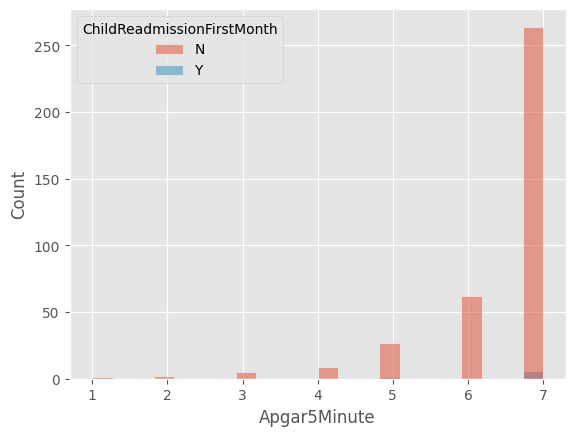

In [49]:
import seaborn as sns
#sns.histplot(data=df,x='ChildReadmissionFirstMonth',y='Apgar5Minute')
sns.histplot(data=df[df.Apgar5Minute<8],hue='ChildReadmissionFirstMonth',x='Apgar5Minute')

In [55]:
df[(df.Apgar5Minute<8)].ChildLengthOfStayHours.describe()

count    377.000000
mean      62.954907
std       22.537217
min        0.000000
25%       49.000000
50%       59.000000
75%       75.000000
max      179.000000
Name: ChildLengthOfStayHours, dtype: float64

In [ ]:
df[df.ChildReadmissionFirstMonth=='Y'].MaxTranscutaneousBilirubin.plot(kind='box')
df[df.ChildReadmissionFirstMonth=='N'].MaxTranscutaneousBilirubin.plot(kind='box')

In [65]:
#df[df.Phototherapy=='Y'].ChildReadmissionFirstMonth.value_counts()
df[df.ChildReadmissionFirstMonth=='Y'].PercentWeightLoss.describe()

count    222.000000
mean      -5.463514
std        2.738013
min      -11.600000
25%       -7.400000
50%       -5.700000
75%       -3.725000
max        2.500000
Name: PercentWeightLoss, dtype: float64

In [123]:
df[df.MaxTranscutaneousBilirubin<2].MaternalRace.value_counts()

MaternalRace
Caucasian                           882
Black race                          130
Multiracial                          34
Race: [other] or [not stated]        32
Asians                                5
American Indian or Alaska Native      1
Name: count, dtype: int64

In [116]:
missing_gestational_age_weeks = df['MaxTranscutaneousBilirubin'].isna().sum()
print(f"Missing values in GestationalAge_Weeks: {missing_gestational_age_weeks}")

Missing values in GestationalAge_Weeks: 105


In [111]:
df[df.GestationalAge_Weeks<35].ChildReadmissionFirstMonth.value_counts()

ChildReadmissionFirstMonth
N    0
Y    0
Name: count, dtype: int64

In [110]:
1479+35

1514

In [125]:
print(feature_summary(data=df, feature='MaxTranscutaneousBilirubin'))
print(feature_summary(data=df, feature='ChildOfficeVisitsFirstMonth'))
#feature_summary(data=df, feature='MaxTranscutaneousBilirubin')

{'Feature Type': 'Numerical', 'Missing Values': 105, 'Count of Numeric Entries': 32781, 'Q1 (25%)': 5.2, 'Q2 (Median)': 7.1, 'Q3 (75%)': 9.1}
{'Feature Type': 'Numerical', 'Missing Values': 0, 'Count of Numeric Entries': 32886, 'Q1 (25%)': 2.0, 'Q2 (Median)': 3.0, 'Q3 (75%)': 3.0}


In [89]:
df[df.DeliveryType=='Vaginal']['Vaginal delivery'].value_counts()

Vaginal delivery
Y    15864
N     6953
Name: count, dtype: int64

In [136]:
na_sums = df[df['ChildReadmissionFirstMonth'] == 'Y'].isna().sum()

# Keep only those with counts greater than 0
na_sums_filtered = na_sums[na_sums > 0]
(na_sums_filtered/2.22).round(2)

YearsOfEducation                    94.14
Parity                              18.02
ChildDeathDate                      99.10
MaternalDeathDate                  100.00
DeliveryType                         1.35
Mother_BMI_AtDelivery               18.02
PrePregnancyWeight_KG               28.38
HepB_PositiveDuringPregnancy         1.35
HCV_PositiveDuringPregnancy         73.42
HIV_PositiveDuringPregnancy          1.35
SyphilisPositiveDuringPregnancy      7.66
GBS_PositiveDuringPregnancy         23.87
Apgar1Minute                         0.45
Apgar5Minute                         0.45
Cord_pH_Venous_Date                 77.03
Cord_pH_Venous                      77.03
Cord_pH_Arterial_Date               41.89
Cord_pH_Arterial                    41.89
MinBloodGlucose                     54.05
MaxBloodGlucose                     54.05
MinSerumBilirubin                   54.95
MaxSerumBilirubin                   54.95
CarSeatTestFailures                 81.53
FeedingType                       

In [ ]:
# High risk data
'MaternalPatientID', 'MaternalMedicalRecordNumber', 'ChildPatientID','ChildMedicalRecordNumber', 'ChildEncounterID', 
# Clinic Data
# Maternal Demographic Characteristics
'MaternalAgeAtDelivery','MaternalRace', 'MaternalLanguage', 
'MyChartAccess',
'LatestMaritalStatus', 'YearsOfEducation', 'Gravida', 'Parity',
'DeliveryDate', 'GestationalAge_Weeks', 'GestAge_Days',
'ChildDeathDate', 'MaternalDeathDate', 
# Children demographic characteristics
'ChildGender', 'ChildRace','ChildEthnicity',

# Prenatal Characteristics
'Mother_BMI_AtDelivery', 'PrePregnancyWeight_KG',
'SSRI_DuringPregnancy', 'Suboxone_DuringPregnancy',
'Methadone_DuringPregnancy', 'PositiveDrugScreenDuringPregnancy',
'HepB_PositiveDuringPregnancy', 'HCV_PositiveDuringPregnancy',
'HIV_PositiveDuringPregnancy', 'SyphilisPositiveDuringPregnancy',
'GBS_PositiveDuringPregnancy', 'Alcohol abuse',
'Antepartum Haemorrhage', 'Eclampsia', 'IUGR',
'Maternal chronic hypertension', 'Maternal Diabetes',
'Maternal pregnancy-induced hypertension', 'Oligohydramnios',
'Placenta previa', 'Polyhydramnios', 'Pre-eclampsia',
'Pregnancy Complications', 'Preterm premature rupture of membranes',
'Smoking during pregnancy', 'Spontaneous abortion',
'Umbilical cord prolapse', 'Vaginal delivery',
 
# Natal and Delivery Characteristics
'DeliveryType', 'ROM_Time', 'MultipleGestation',
# ER visit Characteristics
'ER_VisitDuringPregnancy', 'ChildER_VisitFirstMonth',
'ChildReadmissionFirstMonth', 'ChildOfficeVisitsFirstMonth',
# Ward characteristics
'ChildLengthOfStayHours', 'DischargeMonth','BirthWeight_Grams',
'SGA', 
       
       'AppointmentMadeDuringAdmission', 'Apgar1Minute', 'Apgar5Minute',
       'Cord_pH_Venous_Date', 'Cord_pH_Venous', 'Cord_pH_Arterial_Date',
       'Cord_pH_Arterial', 'MaxHeartRate', 'MinHeartRate', 'AvgHeartRate',
       'AvgPulseOx', 'Desaturations', 'MaxTemperature', 'MinTemperature',
       'MinBloodGlucose', 'MaxBloodGlucose', 'MinSerumBilirubin',
       'MaxSerumBilirubin', 'MaxTranscutaneousBilirubin',
       'MinTranscutaneousBilirubin', 'Phototherapy', 'FailedHearing',
       'CarSeatTestFailures', 'FeedingType', 'PercentWeightLoss'